# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 20.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r20-0-0`.

### Test case LVV-T1264: Verify implementation of archiving camera test data

Verify that a subset of camera test data has been ingested into Butler repos and is available through standard data access tools.

In [1]:
# Confirm that the version of the Science Pipelines is v20_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)
import lsst.daf.persistence as dafPersist ### Gen 2 Butler (dafPersist.Butler)

In [3]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (9, 8)})
plt.rcParams.update({'font.size' : 18})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

### Load and examine some camera test-stand data

We will work with data from the "LDM-503-11a: ComCam OPS Readiness Test Plan and Report" test campaign.

In [4]:
# The path to the data from the most recent Operations Rehearsal is:
repo_path = '/project/shared/comCam/rerun/CALSET_20200729_1847_v2/'

In [5]:
butler = dafPersist.Butler(repo_path)

In [6]:
# These data consist of biases and flats, with the following required dataId dimensions:
# {'detectorName', 'dateObs', 'raftName'}
# 2020-10-28|R22|S00
# Pick a visit/ccd at random:
dataId = {'dateObs': '2020-10-28', 'raftName': 'R22', 'detectorName': 'S00', 'filter': 'r'}

# Load a bias image
bias = butler.get('bias', **dataId)

## Load a flat image
flat = butler.get('flat', **dataId)

In [7]:
# Extract the images and normalize them:
biasim = bias.image.array

# Create an ImageNormalize object
biasnorm = ImageNormalize(biasim, interval=ZScaleInterval(),
                          stretch=LinearStretch())

flatim = flat.image.array

# Create an ImageNormalize object
flatnorm = ImageNormalize(flatim, interval=ZScaleInterval(),
                          stretch=LinearStretch())

### Display the bias and flat images (note that these have already been ISR-corrected)

In [8]:
np.count_nonzero(np.isfinite(biasim))

16288000

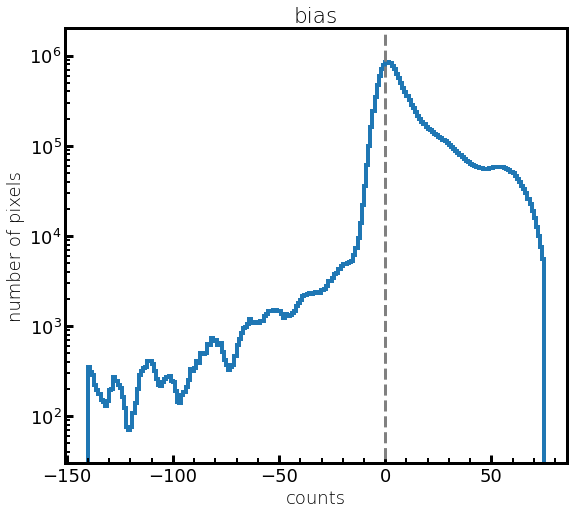

In [9]:
okbiaspix = biasim[np.isfinite(biasim)]
plt.hist(okbiaspix, bins=np.arange(np.percentile(okbiaspix, 0.05), np.percentile(okbiaspix, 99.95), 1),
         histtype='step', linewidth=4, log=True)
plt.vlines(0, 1e-5, 5e6, color='gray', linestyle='--', linewidth=3)
plt.ylim(3e1, 2e6)
plt.xlabel('counts')
plt.ylabel('number of pixels')
plt.title('bias')
plt.minorticks_on()
plt.show()

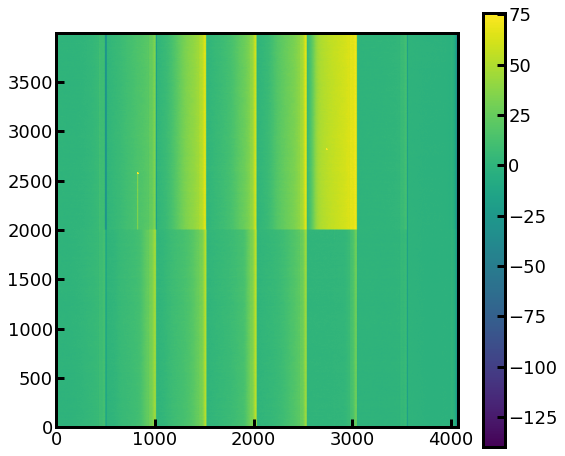

In [10]:
plt.imshow(biasim, norm=biasnorm, origin='lower',
           vmax=np.percentile(biasim,99.95), vmin=np.percentile(biasim, 0.05))
plt.colorbar()
plt.show()

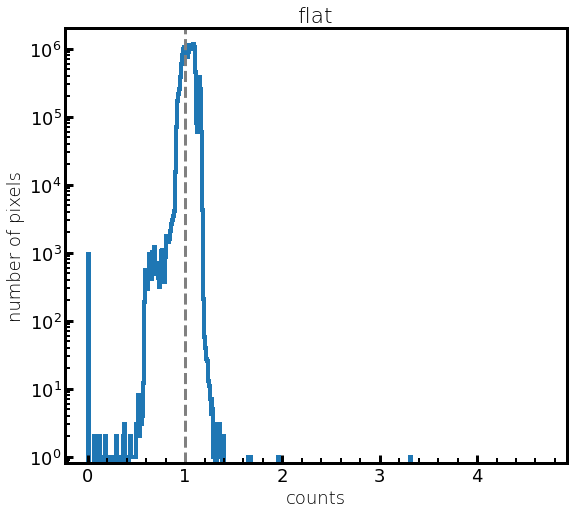

In [11]:
okflatpix = flatim[np.isfinite(flatim)]
plt.hist(okflatpix, bins=np.arange(np.min(okflatpix), np.max(okflatpix), 0.01),
         histtype='step', linewidth=4, log=True)
plt.vlines(1, 1e-5, 5e6, color='gray', linestyle='--', linewidth=3)
plt.ylim(8e-1, 2e6)
plt.xlabel('counts')
plt.ylabel('number of pixels')
plt.title('flat')
plt.minorticks_on()
plt.show()

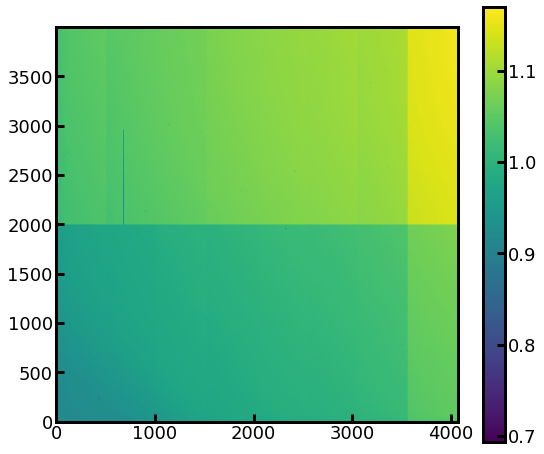

In [12]:
plt.imshow(flatim, norm=flatnorm, origin='lower', 
           vmax=np.percentile(flatim,99.95), vmin=np.percentile(flatim, 0.05))
plt.colorbar()
plt.show()

The images look well-formed. The bias has pixel values (roughly) centered on zero, and the flat has a median near 1.0, as expected. These archived data appear to be fine; thus we consider the results of this test to be a **pass**.